### 0 - import library

In [68]:
# import pyreadr as py
import missingno as msno
import pandas as pd
from matplotlib import pyplot as plt

In [69]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import model_from_json


print("keras.__version__: " + str(keras.__version__))
import tensorflow.keras.backend as K

keras.__version__: 2.2.4-tf


In [70]:
import platform
import sys


os_windows = False
os_ubuntu = False
if platform.platform() == "Linux-5.4.0-58-generic-x86_64-with-glibc2.10":
    os_ubuntu = True
else:
    os_windows = True
print("os_windows: " + str(os_windows))
print("os_ubuntu: " + str(os_ubuntu))

print("sys.version: " + str(sys.version))

os_windows: True
os_ubuntu: False
sys.version: 3.7.1 (default, Oct 28 2018, 08:39:03) [MSC v.1912 64 bit (AMD64)]


In [71]:
import math

In [72]:
import sklearn


print(sklearn.__version__)

0.23.2


In [73]:
import xgboost


print(xgboost.__version__)

0.90


### 1 - define helper function

In [74]:
def data_timesteps_prep(train_normalized_2D, time_steps):
    shape0_old = train_normalized_2D.shape[0]
    features = train_normalized_2D.shape[1]

    shape0 = int(shape0_old / time_steps)
    shape1 = time_steps
    shape2 = features
    train_normalized_3D = np.zeros((shape0, shape1, shape2))

    row_index = 0
    for i in range(shape0):
        train_normalized_3D[i, :, :] = train_normalized_2D[row_index : row_index + time_steps, :]
        row_index = row_index + time_steps
    return train_normalized_3D

In [75]:
def data_timesteps_inv(train_normalized_3D):
    time_steps = train_normalized_3D.shape[1]
    if time_steps == 1:
        return np.squeeze(train_normalized_3D, axis=1)
    features = train_normalized_3D.shape[2]
    rows = train_normalized_3D.shape[0] * time_steps
    train_normalized_2D = np.zeros((rows, features))
    for i in range(train_normalized_3D.shape[0]):
        train_normalized_2D[i * time_steps : i * time_steps + time_steps, :] = train_normalized_3D[i, :, :]
    return train_normalized_2D

In [76]:
def data_timesteps_prep_overlapping(train_normalized_2D, time_steps, overlapping):
    if time_steps != 1:
        shape0_old = train_normalized_2D.shape[0]
        features = train_normalized_2D.shape[1]

        # slide windows of size time_steps, slide step is overlapping
        shape0 = math.floor((shape0_old - time_steps) / overlapping) + 1
        shape1 = time_steps
        shape2 = features
        train_normalized_3D = np.zeros((shape0, shape1, shape2))

        row_index = 0
        for i in range(shape0):
            train_normalized_3D[i, :, :] = train_normalized_2D[row_index : row_index + time_steps, :]
            row_index = row_index + overlapping
    elif time_steps == 1:
        return data_timesteps_prep(train_normalized_2D, 1)
    return train_normalized_3D

In [77]:
def data_timesteps_overlapping_inv(train_normalized_3D, overlapping):
    shape0 = train_normalized_3D.shape[0]
    time_steps = train_normalized_3D.shape[1]
    features = train_normalized_3D.shape[2]
    rows = (shape0 - 1) * overlapping + time_steps
    train_normalized_2D = np.zeros((rows, features))

    row_index = 0
    for i in range(train_normalized_3D.shape[0]):
        train_normalized_2D[row_index : row_index + time_steps, :] = train_normalized_3D[i, :, :]
        row_index = row_index + overlapping
    return train_normalized_2D

In [78]:
def plot_pred_3D(
    plot_range, feature, data_normalized_3D, data_normalized_pred_3D, label1, label2, if_faultFree, overlapping, set_overlapping=False,
):
    if set_overlapping:
        data_normalized = data_timesteps_overlapping_inv(data_normalized_3D, overlapping)
        data_normalized_pred = data_timesteps_overlapping_inv(data_normalized_pred_3D, overlapping)
    else:
        data_normalized = data_timesteps_inv(data_normalized_3D)
        data_normalized_pred = data_timesteps_inv(data_normalized_pred_3D)

    fig, (ax1, ax2, ax3) = plt.subplots(3)

    if if_faultFree:
        ax1.plot(
            range(plot_range), data_normalized[:plot_range, feature], label=label1, color="y",
        )
        ax1.legend()

        ax2.plot(
            range(plot_range), data_normalized_pred[:plot_range, feature], label=label2, color="b",
        )
        ax2.legend()

        ax3.plot(
            range(plot_range), data_normalized[:plot_range, feature], label=label1, color="y",
        )
        ax3.plot(
            range(plot_range), data_normalized_pred[:plot_range, feature], label=label2, color="b",
        )
        ax3.legend()
    else:
        ax1.plot(
            range(plot_range), data_normalized[:plot_range, feature], label=label1, color="r",
        )
        ax1.legend()

        ax2.plot(
            range(plot_range), data_normalized_pred[:plot_range, feature], label=label2, color="g",
        )
        ax2.legend()

        ax3.plot(
            range(plot_range), data_normalized[:plot_range, feature], label=label1, color="r",
        )
        ax3.plot(
            range(plot_range), data_normalized_pred[:plot_range, feature], label=label2, color="g",
        )
        ax3.legend()

    plt.show()

In [79]:
def pred_error_3D(
    threshold, feature_list, plot_range, data_normalized_3D, data_normalized_pred_3D, label, overlapping, set_overlapping=False,
):
    if set_overlapping:
        data_normalized = data_timesteps_overlapping_inv(data_normalized_3D, overlapping)
        data_normalized_pred = data_timesteps_overlapping_inv(data_normalized_pred_3D, overlapping)
    else:
        data_normalized = data_timesteps_inv(data_normalized_3D)
        data_normalized_pred = data_timesteps_inv(data_normalized_pred_3D)

    i = 0
    data_loss = np.zeros(shape=(data_normalized.shape[0], len(feature_list),))
    for feature in feature_list:
        data_loss[:, i] = data_normalized[:, feature] - data_normalized_pred[:, feature]
        i = i + 1
    data_loss = np.mean(np.square(data_loss), axis=1)
    anomaly_points = data_loss > threshold
    s = label + ": " + str(anomaly_points.sum() / data_loss.shape[0])
    print(s)
    return anomaly_points.sum() / data_loss.shape[0]

In [80]:
def normalization_data(data, eta=2):
    data_normalized = np.copy(data)
    shape0 = data.shape[0]
    shape1 = data.shape[1]
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    for i in range(shape1):
        for j in range(shape0):
            data_normalized[j, i] = (data[j, i] - mean[i]) / (std[i] * eta)
    return data_normalized

In [81]:
def fit_epochs_3D(
    model_pathAndname,
    model,
    epochs,
    epochs_step,
    plot_range,
    fault_free_train_normalized_3D,
    fault_free_test1_normalized_3D,
    fault_free_test2_normalized_3D,
    faultytrain_faultfree0_20_normalized_3D,
    faultytest_faultfree0_160_normalized_3D,
    faulty_train_normalized_3D,
    faulty_test_normalized_3D,
    model_fit_verbose,
    threshold=0.0032,
    feature_list=[0, 43],
    epochs_start=5,
    set_half_output=False,
    hiding_dim=52,
):
    false_alarm = np.zeros(1)
    detection_rate = np.zeros(1)

    if epochs_start < 5:
        epochs_start = 5

    for epoch in range(epochs_step, epochs, epochs_step):
        print()
        print("Epochs: " + str(epoch))
        history = model.fit(
            fault_free_train_normalized_3D,
            fault_free_train_normalized_3D,
            epochs=epochs_step,
            verbose=model_fit_verbose,
            validation_data=(fault_free_test1_normalized_3D, fault_free_test1_normalized_3D,),
        )
        if epoch > epochs_start or epoch == epochs_start:
            temp_model_pathAndname = model_pathAndname + "_epoch=" + str(epoch) + ".json"
            temp_weight_pathAndname = model_pathAndname + "_weights_epoch=" + str(epoch) + ".h5"
            save_model_weights(
                model, temp_model_pathAndname, temp_weight_pathAndname,
            )
            if set_half_output:
                fault_free_train_normalized_pred_3D = model.predict(fault_free_train_normalized_3D)[:, :, :52]
                fault_free_test1_normalized_pred_3D = model.predict(fault_free_test1_normalized_3D)[:, :, :52]
                fault_free_test2_normalized_pred_3D = model.predict(fault_free_test2_normalized_3D)[:, :, :52]

                faultytrain_faultfree0_20_normalized_pred_3D = model.predict(faultytrain_faultfree0_20_normalized_3D)[:, :, :52]
                faultytest_faultfree0_160_normalized_pred_3D = model.predict(faultytest_faultfree0_160_normalized_3D)[:, :, :52]

                faulty_test_normalized_pred_3D = model.predict(faulty_test_normalized_3D)[:, :, :52]
                faulty_train_normalized_pred_3D = model.predict(faulty_train_normalized_3D)[:, :, :52]  # save computation time
            else:
                fault_free_train_normalized_pred_3D = model.predict(fault_free_train_normalized_3D)
                fault_free_test1_normalized_pred_3D = model.predict(fault_free_test1_normalized_3D)
                fault_free_test2_normalized_pred_3D = model.predict(fault_free_test2_normalized_3D)

                faultytrain_faultfree0_20_normalized_pred_3D = model.predict(faultytrain_faultfree0_20_normalized_3D)
                faultytest_faultfree0_160_normalized_pred_3D = model.predict(faultytest_faultfree0_160_normalized_3D)

                faulty_test_normalized_pred_3D = model.predict(faulty_test_normalized_3D)
                faulty_train_normalized_pred_3D = model.predict(faulty_train_normalized_3D)  # save computation time

            Status_Info = "Epoch: " + str(epoch)
            print()
            print(Status_Info)

            pred_error_3D(
                threshold,
                feature_list,
                plot_range,
                fault_free_train_normalized_3D,
                fault_free_train_normalized_pred_3D,
                "fault_free_train",
                overlapping,
                set_overlapping,
            )
            pred_error_3D(
                threshold,
                feature_list,
                plot_range,
                fault_free_test1_normalized_3D,
                fault_free_test1_normalized_pred_3D,
                "fault_free_test1",
                overlapping,
                set_overlapping,
            )
            f_temp = pred_error_3D(
                threshold,
                feature_list,
                plot_range,
                fault_free_test2_normalized_3D,
                fault_free_test2_normalized_pred_3D,
                "fault_free_test2",
                overlapping,
                set_overlapping,
            )

            pred_error_3D(
                threshold,
                feature_list,
                plot_range,
                faultytrain_faultfree0_20_normalized_3D,
                faultytrain_faultfree0_20_normalized_pred_3D,
                "faultytrain_faultfree0_20",
                overlapping,
                set_overlapping,
            )
            pred_error_3D(
                threshold,
                feature_list,
                plot_range,
                faultytest_faultfree0_160_normalized_3D,
                faultytest_faultfree0_160_normalized_pred_3D,
                "faultytest_faultfree0_160",
                overlapping,
                set_overlapping,
            )
            pred_error_3D(
                threshold,
                feature_list,
                plot_range,
                faulty_train_normalized_3D,
                faulty_train_normalized_pred_3D,
                "faulty_train",
                overlapping,
                set_overlapping,
            )
            d_temp = pred_error_3D(
                threshold,
                feature_list,
                plot_range,
                faulty_test_normalized_3D,
                faulty_test_normalized_pred_3D,
                "faulty_test",
                overlapping,
                set_overlapping,
            )

            false_alarm = np.append(false_alarm, f_temp)
            detection_rate = np.append(detection_rate, d_temp)

    x_axis = list(range(epochs_start, epochs, epochs_step))
    plt.figure(figsize=(5, 5))
    plt.plot(
        x_axis, false_alarm[1:], label="False Alarm",
    )
    plt.plot(
        x_axis, detection_rate[1:], label="Detection Rate",
    )
    plt.grid()
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.show()
    return false_alarm[1:], detection_rate[1:]

In [82]:
def print_model_history(history):

    # list all data in history
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

    # summarize history for loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

In [83]:
def save_model_weights(model, model_pathAndname, weight_pathAndname):

    # serialize model to JSON
    model_json = model.to_json()

    with open(model_pathAndname, "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    model.save_weights(weight_pathAndname)
    print("Saved model and weights to disk")


def load_model_weights(model_pathAndname, weight_pathAndname):

    # load json and create model
    json_file = open(model_pathAndname, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # load weights into new model
    loaded_model.load_weights(weight_pathAndname)
    print("Loaded model and weights from disk")
    return loaded_model

In [84]:
def print_model_info(
    model_index,
    time_steps,
    eta,
    input_train_data,
    output_train_data,
    input_validation_data,
    output_validation_data,
    set_overlapping,
    overlapping,
    batch_size=0,
    set_batch_size=False,
):
    print("model_index: " + str(model_index))
    print("time_steps: " + str(time_steps))
    print("set_overlapping: " + str(set_overlapping)+", overlapping: " + str(overlapping))
    
    if set_batch_size and batch_size != 0:
        print("set_batch_size: " + str(set_batch_size)+"batch_size: " + str(batch_size))

    print("eta: " + str(eta))
    
    print("input_train_data.shape: " + str(input_train_data.shape))
    print("output_train_data.shape: " + str(output_train_data.shape))
    print("input_validation_data.shape: " + str(input_validation_data.shape))
    print("output_validation_data.shape: " + str(output_validation_data.shape))

#     if set_batch_size and batch_size!=0:
#         print("set_batch_size: " + str(set_batch_size))
#         print("batch_size: " + str(batch_size))

#     if set_batch_size and set_overlapping and time_steps != 1:
#         batch_size = math.floor((500 - time_steps) / overlapping) + 1
#         print("set_batch_size: " + str(set_batch_size))
#         print("batch_size: " + str(batch_size))
#     elif set_batch_size and time_steps == 1:
#         batch_size = math.floor(500 / time_steps)
#         print("set_batch_size: " + str(set_batch_size))
#         print("batch_size: " + str(batch_size))

In [85]:
def custom_loss_001(sparsity_penalty, sparsity_para, hiding_dim):

    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true, y_pred):
        kl_para_1 = K.mean(y_pred[:, :, 52:], axis=-1)
        kl_para_2 = K.mean(y_pred[:, :, 52:] + sparsity_para - y_pred[:, :, 52:], axis=-1)
        return K.mean(
            K.square(y_pred[:, :, :52] - y_true), axis=-1
        ) + sparsity_penalty * keras.losses.kullback_leibler_divergence(kl_para_1, kl_para_2)

    return loss

In [86]:
def custom_accuracy_001(hiding_dim):
    #     y_true = K.ones_like(y_true[:, :, hiding_dim:])
    #     true_positives = K.sum(K.round(K.clip(y_true * y_pred[:, :, hiding_dim:], 0, 1)))

    #     predicted_positives = K.sum(K.round(K.clip(y_pred[:, :, hiding_dim:], 0, 1)))
    #     precision = true_positives / (predicted_positives + K.epsilon())
    def accuracy(y_true, y_pred):
#         print("y_true: "+str(y_true))
#         print("y_pred: "+str(y_pred))
#         print("K.argmax(y_true, axis=-1): "+str(K.argmax(y_true, axis=-1)))
        return keras.metrics.categorical_accuracy(y_true, y_pred[:, :, :52])
    return accuracy

### 2.1 - read data

In [87]:
if os_windows:
    root_folder = "C:/Users/liang/Masterarbeit_Jupyter_Lab/"
else:
    root_folder = ""

### 2.2 - data normalization

In [88]:
eta = 2
print("eta: " + str(eta))

eta: 2


In [89]:
read_data, normalize_data = True, True

if read_data and normalize_data:
    fault_free_train_samplesize20000 = pd.read_csv(
        root_folder + "data_set_csv/fault_free_train_sample_size=20000", sep=",", header=None,
    ).to_numpy()
    fault_free_train_samplesize40000 = pd.read_csv(
        root_folder + "data_set_csv/fault_free_train_sample_size=40000", sep=",", header=None,
    ).to_numpy()
    fault_free_train_samplesize100000 = pd.read_csv(
        root_folder + "data_set_csv/fault_free_train_sample_size=100000", sep=",", header=None,
    ).to_numpy()
    fault_free_train_samplesize250000 = pd.read_csv(
        root_folder + "data_set_csv/fault_free_train_sample_size=250000", sep=",", header=None,
    ).to_numpy()

    fault_free_train_samplesize20000_normalized = normalization_data(fault_free_train_samplesize20000, eta)
#     fault_free_train_samplesize40000_normalized = normalization_data(fault_free_train_samplesize40000, eta)
#     fault_free_train_samplesize100000_normalized = normalization_data(fault_free_train_samplesize100000, eta)
#     fault_free_train_samplesize250000_normalized = normalization_data(fault_free_train_samplesize250000, eta)

In [90]:
fault_free_test1 = pd.read_csv(root_folder + "data_set_csv/fault_free_test1=20000", sep=",", header=None).to_numpy()
fault_free_test1_normalized = normalization_data(fault_free_test1, eta)
fault_free_test1_normalized.shape

(20000, 52)

In [91]:
fault_free_test2 = pd.read_csv(root_folder + "data_set_csv/fault_free_test2=20000", sep=",", header=None).to_numpy()
fault_free_test2_normalized = normalization_data(fault_free_test2, eta)
fault_free_test2_normalized.shape

(20000, 52)

In [100]:
faultytrain_faultfree0_20 = pd.read_csv(root_folder + "data_set_csv/faultytrain_faultfree0_20", sep=",", header=None).to_numpy()
faultytrain_faultfree0_20_normalized = normalization_data(faultytrain_faultfree0_20, eta)[:20000,:]
faultytrain_faultfree0_20_normalized.shape

(20000, 52)

In [101]:
faultytest_faultfree0_160 = pd.read_csv(root_folder + "data_set_csv/faultytest_faultfree0_160", sep=",", header=None).to_numpy()
faultytest_faultfree0_160_normalized = normalization_data(faultytest_faultfree0_160, eta)[:20000,:]
faultytest_faultfree0_160_normalized.shape

(20000, 52)

In [102]:
faulty_train = pd.read_csv(root_folder + "data_set_csv/faulty_train=1%", sep=",", header=None).to_numpy()
faulty_train_normalized = normalization_data(faulty_train, eta)[:20000,:]
faulty_train_normalized.shape

(20000, 52)

In [103]:
faulty_test = pd.read_csv(root_folder + "data_set_csv/faulty_test=1%", sep=",", header=None).to_numpy()
faulty_test_normalized = normalization_data(faulty_test, eta)[:20000,:]
faulty_test_normalized.shape

(20000, 52)

In [ ]:
# release memory
fault_free_train_samplesize20000=0
fault_free_train_samplesize40000=0
fault_free_train_samplesize100000=0
fault_free_train_samplesize250000=0
fault_free_test1=0
fault_free_test2=0
faultytrain_faultfree0_20=0
faultytest_faultfree0_160=0
faulty_train=0
faulty_test=0

### 2.3 - transform data in 3D

In [104]:
time_steps = 1
features = 52

set_overlapping = False
overlapping = 1

inv_timesteps_features = False

if set_overlapping:
    print("time_steps: " + str(time_steps))
    print("set_overlapping: " + str(set_overlapping))
    print("overlapping: " + str(overlapping))
    fault_free_train_samplesize20000_normalized_3D = data_timesteps_prep_overlapping(
        fault_free_train_samplesize20000_normalized, time_steps, overlapping
    )
    fault_free_train_samplesize40000_normalized_3D = data_timesteps_prep_overlapping(
        fault_free_train_samplesize40000_normalized, time_steps, overlapping
    )
    fault_free_train_samplesize100000_normalized_3D = data_timesteps_prep_overlapping(
        fault_free_train_samplesize100000_normalized, time_steps, overlapping
    )
    fault_free_train_samplesize250000_normalized_3D = data_timesteps_prep_overlapping(
        fault_free_train_samplesize250000_normalized, time_steps, overlapping
    )

    #     if os_windows:
    #         fault_free_test_samplesize480000_normalized_3D=data_timesteps_prep_overlapping(fault_free_test_samplesize480000_normalized, time_steps, overlapping)

    fault_free_test1_normalized_3D = data_timesteps_prep_overlapping(fault_free_test1_normalized, time_steps, overlapping)
    fault_free_test2_normalized_3D = data_timesteps_prep_overlapping(fault_free_test2_normalized, time_steps, overlapping)

    faultytrain_faultfree0_20_normalized_3D = data_timesteps_prep_overlapping(
        faultytrain_faultfree0_20_normalized, time_steps, overlapping
    )
    faultytest_faultfree0_160_normalized_3D = data_timesteps_prep_overlapping(
        faultytest_faultfree0_160_normalized, time_steps, overlapping
    )

    faulty_train_normalized_3D = data_timesteps_prep_overlapping(faulty_train_normalized, time_steps, overlapping)
    faulty_test_normalized_3D = data_timesteps_prep_overlapping(faulty_test_normalized, time_steps, overlapping)

elif inv_timesteps_features:
    print("time_steps: " + str(time_steps))
    print("inv_timesteps_features: " + str(inv_timesteps_features))
    fault_free_train_samplesize20000_normalized_3D = data_timesteps_prep(
        fault_free_train_samplesize20000_normalized, time_steps
    ).transpose(0, 2, 1)
    fault_free_train_samplesize40000_normalized_3D = data_timesteps_prep(
        fault_free_train_samplesize40000_normalized, time_steps
    ).transpose(0, 2, 1)
    fault_free_train_samplesize100000_normalized_3D = data_timesteps_prep(
        fault_free_train_samplesize100000_normalized, time_steps
    ).transpose(0, 2, 1)
    fault_free_train_samplesize250000_normalized_3D = data_timesteps_prep(
        fault_free_train_samplesize250000_normalized, time_steps
    ).transpose(0, 2, 1)

    #     if os_windows:
    #         fault_free_test_samplesize480000_normalized_3D=data_timesteps_prep(fault_free_test_samplesize480000_normalized, time_steps)

    fault_free_test1_normalized_3D = data_timesteps_prep(fault_free_test1_normalized, time_steps).transpose(0, 2, 1)
    fault_free_test2_normalized_3D = data_timesteps_prep(fault_free_test2_normalized, time_steps).transpose(0, 2, 1)

    faultytrain_faultfree0_20_normalized_3D = data_timesteps_prep(faultytrain_faultfree0_20, time_steps).transpose(0, 2, 1)
    faultytest_faultfree0_160_normalized_3D = data_timesteps_prep(faultytest_faultfree0_160, time_steps).transpose(0, 2, 1)

    faulty_train_normalized_3D = data_timesteps_prep(faulty_train_normalized, time_steps).transpose(0, 2, 1)
    faulty_test_normalized_3D = data_timesteps_prep(faulty_test_normalized, time_steps).transpose(0, 2, 1)

elif not inv_timesteps_features and not set_overlapping:
    print("time_steps: " + str(time_steps))
    print("set_overlapping: False")
    fault_free_train_samplesize20000_normalized_3D = data_timesteps_prep(fault_free_train_samplesize20000_normalized, time_steps)
    fault_free_train_samplesize40000_normalized_3D = data_timesteps_prep(fault_free_train_samplesize40000_normalized, time_steps)
    fault_free_train_samplesize100000_normalized_3D = data_timesteps_prep(
        fault_free_train_samplesize100000_normalized, time_steps
    )
    fault_free_train_samplesize250000_normalized_3D = data_timesteps_prep(
        fault_free_train_samplesize250000_normalized, time_steps
    )

    #     if os_windows:
    #         fault_free_test_samplesize480000_normalized_3D=data_timesteps_prep(fault_free_test_samplesize480000_normalized, time_steps)

    fault_free_test1_normalized_3D = data_timesteps_prep(fault_free_test1_normalized, time_steps)
    fault_free_test2_normalized_3D = data_timesteps_prep(fault_free_test2_normalized, time_steps)

    faultytrain_faultfree0_20_normalized_3D = data_timesteps_prep(faultytrain_faultfree0_20_normalized, time_steps)
    faultytest_faultfree0_160_normalized_3D = data_timesteps_prep(faultytest_faultfree0_160_normalized, time_steps)

    faulty_train_normalized_3D = data_timesteps_prep(faulty_train_normalized, time_steps)
    faulty_test_normalized_3D = data_timesteps_prep(faulty_test_normalized, time_steps)

time_steps: 1
set_overlapping: False


### 3 - build model

In [105]:
# custom_early_stopping = EarlyStopping(monitor="val_loss", patience=50, min_delta=0.0001, mode="min")

# ----------------------------------------


def build_model(
    model_index, time_steps=1, set_batch_size=False, batch_size=0, sparsity_penalty=0.1, sparsity_para=0, hiding_dim=48
):
    model = keras.Sequential()

    # model - naive AE 0.0 baseline
    # best result:
    # Epoch: 220
    # Sample size: 250000
    # fault_free_test2: 0.18
    # faulty_test: 0.83
    if model_index == 0:
        encoding_dim = 46
        model = keras.Sequential()
        model.add(keras.Input(shape=(time_steps, features)))
        # model.add(layers.Dropout(0.1, input_shape=(52,)))
        model.add(layers.Dense(encoding_dim, activation="sigmoid"))
        model.add(layers.Dense(52, activation="tanh"))

    # model - naive AE 0.1
    if model_index == 0.1:
        model = keras.Sequential()
        model.add(keras.Input(shape=(time_steps, features)))
        # model.add(layers.Dropout(0.1, input_shape=(52,)))
        model.add(layers.Dense(46, activation="sigmoid"))
        model.add(layers.Dense(48, activation="sigmoid"))
        model.add(layers.Dense(46, activation="sigmoid"))
        model.add(layers.Dense(52, activation="tanh"))

    # model - naive AE 0.2
    if model_index == 0.2:
        encoding_dim = 48
        model = keras.Sequential()
        model.add(keras.Input(shape=(time_steps, features)))
        # model.add(layers.Dropout(0.1, input_shape=(52,)))
        model.add(layers.Dense(encoding_dim, activation="sigmoid"))
        model.add(layers.Dense(52, activation="tanh"))

    # ------------------------------------------------------------------------------------------------------------------------

    if model_index == 0.3:

        #         sparsity_penalty, sparsity_para, hiding_dim = 0.1, 0, 48
        input_layer = keras.Input(shape=(1, 52))
        dense_layer_1 = layers.Dense(hiding_dim, activation="sigmoid")(input_layer)
        output_layer = layers.Dense(52, activation="tanh")(dense_layer_1)
        output_layer = layers.concatenate([output_layer, dense_layer_1])
        model = keras.Model(inputs=input_layer, outputs=output_layer)
        model.compile(
            loss=custom_loss_001(sparsity_penalty, sparsity_para, hiding_dim),
            optimizer="adam",
            metrics=[custom_accuracy_001(hiding_dim)],
        )

        #         keras.utils.plot_model(model_001, show_shapes=True, show_layer_names=True)
        print(model.summary())
        return model

    # ------------------------------------------------------------------------------------------------------------------------

    # model - LSTM 1.0 - no modification allowed
    # basic model, baseline performance
    # good result for time_steps=1
    # best result:
    # Epoch: 220
    # Sample size: 20000/40000
    # fault_free_test2: 0.20745
    # faulty_test: 0.8565063775510204
    # problem: how to adapt to time_steps>1
    # observation 1: set_batch_size can speed up training, but result may be worse
    if model_index == 1.0:
        model = keras.Sequential()
        model._name = str(model_index)

        if set_batch_size == True:
            model.add(layers.Input(shape=(time_steps, features), batch_size=batch_size))
            model.add(
                layers.LSTM(128, batch_input_shape=(batch_size, time_steps, features), stateful=False, return_sequences=False)
            )
        else:
            model.add(layers.Input(shape=(time_steps, features)))
            model.add(layers.LSTM(128, input_shape=(time_steps, features), stateful=False, return_sequences=False))

        model.add(layers.RepeatVector(time_steps))
        model.add(layers.TimeDistributed(layers.Dense(300, activation="relu")))
        #         model.add(layers.Dropout(0.2))
        model.add(layers.TimeDistributed(layers.Dense(52, activation="tanh")))

    # model - LSTM 1.1
    # based on LSTM 1.0
    # for time_steps=1
    # try to improve result

    if model_index == 1.1:
        model = keras.Sequential()
        model._name = str(model_index)

        if set_batch_size == True:
            model.add(layers.Input(shape=(time_steps, features), batch_size=batch_size))
            model.add(
                layers.LSTM(128, batch_input_shape=(batch_size, time_steps, features), stateful=False, return_sequences=False)
            )
        else:
            model.add(layers.Input(shape=(time_steps, features)))
            model.add(layers.LSTM(128, input_shape=(time_steps, features), stateful=False, return_sequences=False))

        model.add(layers.RepeatVector(time_steps))
        model.add(
            layers.TimeDistributed(layers.Dense(30, activation="tanh"))
        )  # changes: change dense layer units for compression
        #         model.add(layers.Dropout(0.2))
        model.add(layers.TimeDistributed(layers.Dense(52, activation="tanh")))

    # model - LSTM 1.2
    # based on LSTM 1.0
    # for time_steps=1
    # try to improve result

    if model_index == 1.2:
        model = keras.Sequential()
        model._name = str(model_index)

        if set_batch_size == True:
            model.add(layers.Input(shape=(time_steps, features), batch_size=batch_size))
            model.add(
                layers.LSTM(128, batch_input_shape=(batch_size, time_steps, features), stateful=False, return_sequences=True)
            )
        else:
            model.add(layers.Input(shape=(time_steps, features)))
            model.add(layers.LSTM(128, input_shape=(time_steps, features), stateful=False, return_sequences=True))

        model.add(layers.LSTM(40, return_sequences=True))  # changes: add one LSTM layer for compression

        model.add(layers.TimeDistributed(layers.Dense(30, activation="tanh")))
        model.add(layers.TimeDistributed(layers.Dense(52, activation="tanh")))

    # ------------------------------------------------------------------------------------------------------------------------

    # model LSTM 2.0
    # for time_steps>=1
    # currently not working

    if model_index == 2.0:
        model = keras.Sequential()
        model._name = str(model_index)

        if set_batch_size == True:
            model.add(layers.Input(shape=(time_steps, features), batch_size=batch_size))
            model.add(
                layers.LSTM(128, activation="relu", batch_input_shape=(batch_size, time_steps, features), return_sequences=True)
            )
        else:
            model.add(layers.Input(shape=(time_steps, features)))
            model.add(layers.LSTM(128, activation="relu", input_shape=(time_steps, features), return_sequences=True))

        model.add(layers.LSTM(40, activation="relu", return_sequences=True))
        model.add(layers.TimeDistributed(layers.Dense(52, activation="tanh")))

    # ------------------------------------------------------------------------------------------------------------------------

    # model LSTM 3.0
    # for time_steps>=1
    # better accuracy for time_steps=1
    # remove RepeatVector layer (this layer seems not fit for TEP data)

    if model_index == 3.0:
        model = keras.Sequential()
        model._name = str(model_index)

        if set_batch_size == True:
            model.add(layers.Input(shape=(time_steps, features), batch_size=batch_size))
            model.add(
                layers.LSTM(
                    128,
                    activation="relu",
                    batch_input_shape=(batch_size, time_steps, features),
                    return_sequences=True,
                    stateful=False,
                )
            )

        else:
            model.add(layers.Input(shape=(time_steps, features)))
            model.add(
                layers.LSTM(128, activation="relu", input_shape=(time_steps, features), return_sequences=True, stateful=False)
            )

        model.add(layers.LSTM(64, activation="relu", return_sequences=True, stateful=False))
        #         model.add(layers.Dropout(0.1))
        model.add(layers.LSTM(64, activation="relu", return_sequences=True, stateful=False))
        model.add(layers.LSTM(128, activation="relu", return_sequences=True, stateful=False))
        model.add(layers.TimeDistributed(layers.Dense(52, activation="tanh")))

    # ------------------------------------------------------------------------------------------------------------------------

    # model LSTM 3.1
    # for time_steps>=1
    # better accuracy for time_steps=1
    # remove RepeatVector layer (this layer seems not fit for TEP data)

    if model_index == 3.1:
        model = keras.Sequential()
        model._name = str(model_index)

        if set_batch_size == True:
            model.add(layers.Input(shape=(time_steps, features), batch_size=batch_size))
            model.add(
                layers.LSTM(
                    128,
                    activation="relu",
                    batch_input_shape=(batch_size, time_steps, features),
                    return_sequences=True,
                    stateful=False,
                )
            )

        else:
            model.add(layers.Input(shape=(time_steps, features)))
            model.add(
                layers.LSTM(128, activation="relu", input_shape=(time_steps, features), return_sequences=True, stateful=False)
            )

        model.add(layers.LSTM(64, activation="relu", return_sequences=True, stateful=False))
        model.add(layers.Dropout(0.1))
        model.add(layers.LSTM(64, activation="relu", return_sequences=True, stateful=False))
        model.add(layers.LSTM(128, activation="relu", return_sequences=True, stateful=False))
        model.add(layers.TimeDistributed(layers.Dense(52, activation="tanh")))

    # model LSTM 3.2
    # for time_steps>=1
    # better accuracy for time_steps=1
    # remove RepeatVector layer (this layer seems not fit for TEP data)

    if model_index == 3.2:
        model = keras.Sequential()
        model._name = str(model_index)

        if set_batch_size == True:
            model.add(layers.Input(shape=(time_steps, features), batch_size=batch_size))
            model.add(
                layers.LSTM(
                    128,
                    activation="relu",
                    batch_input_shape=(batch_size, time_steps, features),
                    return_sequences=True,
                    stateful=False,
                )
            )

        else:
            model.add(layers.Input(shape=(time_steps, features)))
            model.add(
                layers.LSTM(128, activation="relu", input_shape=(time_steps, features), return_sequences=True, stateful=False)
            )

        model.add(layers.LSTM(48, activation="relu", return_sequences=True, stateful=False))
        #         model.add(layers.Dropout(0.1))
        model.add(layers.LSTM(48, activation="relu", return_sequences=True, stateful=False))
        model.add(layers.LSTM(128, activation="relu", return_sequences=True, stateful=False))
        model.add(layers.TimeDistributed(layers.Dense(52, activation="tanh")))

    # ------------------------------------------------------------------------------------------------------------------------

    # model LSTM 4.0
    # for time_steps>=1
    # currently not working

    if model_index == 4.0:
        model = keras.Sequential()
        model._name = str(model_index)

        if set_batch_size == True:
            model.add(layers.Input(shape=(time_steps, features), batch_size=batch_size))
            model.add(
                layers.LSTM(128, activation="relu", batch_input_shape=(batch_size, time_steps, features), return_sequences=True)
            )
        else:
            model.add(layers.Input(shape=(time_steps, features)))
            model.add(layers.LSTM(128, activation="relu", input_shape=(time_steps, features), return_sequences=True))

        model.add(layers.LSTM(40, activation="relu", return_sequences=True))
        model.add(layers.TimeDistributed(layers.Dense(150, activation="tanh")))
        model.add(layers.TimeDistributed(layers.Dense(52, activation="tanh")))

    # ------------------------------------------------------------------------------------------------------------------------

    model.compile(loss="mae", optimizer="adam")
#     model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
    print(model.summary())
    return model

### 4 - set model train parameters, model summary

3rd condition
model_index: 0.0
time_steps: 1
set_overlapping: False, overlapping: 1
eta: 2
input_train_data.shape: (20000, 1, 52)
output_train_data.shape: (20000, 1, 52)
input_validation_data.shape: (20000, 1, 52)
output_validation_data.shape: (20000, 1, 52)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1, 46)             2438      
_________________________________________________________________
dense_21 (Dense)             (None, 1, 52)             2444      
Total params: 4,882
Trainable params: 4,882
Non-trainable params: 0
_________________________________________________________________
None


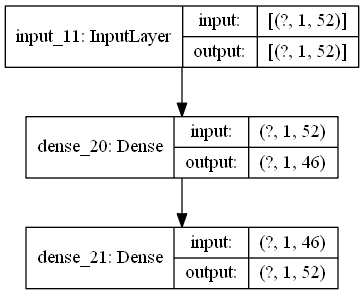

In [106]:
set_batch_size = False
batch_size = 0.0

# model_index = 0.1

model_index = 0.0
sparsity_penalty=0.01
sparsity_para=0
hiding_dim=48

# only one option should be True
# if_test_reconstruct, if_fine_tuning = True, False
# if_test_reconstruct, if_fine_tuning = False, True

input_train_data = fault_free_train_samplesize20000_normalized_3D
output_train_data = fault_free_train_samplesize20000_normalized_3D
samplesize_folder = "/samplesize=20000"

input_validation_data = fault_free_test1_normalized_3D
output_validation_data = fault_free_test1_normalized_3D

# ------------------------------------------------------------------------------------------------------------------------

if set_batch_size and set_overlapping and time_steps != 1:
    batch_size = math.floor((500 - time_steps) / overlapping) + 1
    print("1st condition")
    print_model_info(
        model_index,
        time_steps,
        eta,
        input_train_data,
        output_train_data,
        input_validation_data,
        output_validation_data,
        set_overlapping,
        overlapping,
        batch_size,
        set_batch_size,
    )
    print()
    model = build_model(model_index, time_steps, set_batch_size, batch_size)
elif set_batch_size and time_steps == 1:
    print("2nd condition")
    batch_size = math.floor(500 / time_steps)
    print_model_info(
        model_index,
        time_steps,
        eta,
        input_train_data,
        output_train_data,
        input_validation_data,
        output_validation_data,
        set_overlapping,
        overlapping,
        batch_size,
        set_batch_size,
    )
    model = build_model(model_index, time_steps, set_batch_size, batch_size)
    print()
else:
    print("3rd condition")
    print_model_info(
        model_index,
        time_steps,
        eta,
        input_train_data,
        output_train_data,
        input_validation_data,
        output_validation_data,
        set_overlapping,
        overlapping,
        set_batch_size,
    )
    print()
    model = build_model(model_index, time_steps)
# print(model.summary())
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [107]:
# if_test_reconstruct = True
# if_test_reconstruct=False
# if_fine_tuning = True
# if_fine_tuning = False
# if_test_reconstruct,if_fine_tuning=True, False
if_test_reconstruct,if_fine_tuning=False, True
# if_test_reconstruct,if_fine_tuning=True, True

### 5.1 - test if model can reconstruct data

*model should be able to*
- achieve accuracy >= 60%
- reconstruct main features

In [108]:
if if_test_reconstruct:

    print_model_info(
        model_index,
        time_steps,
        eta,
        input_train_data,
        output_train_data,
        input_validation_data,
        output_validation_data,
        set_overlapping,
        overlapping,
        batch_size,
        set_batch_size,
    )
    print()

    # build a new model
    model = build_model(model_index, time_steps, set_batch_size, batch_size, sparsity_penalty, sparsity_para, hiding_dim)

    # train model ----------------------------------------

    model_folder = "/model" + str(model_index)

    epochs = 200
    model_fit_verbose = 2

    history = model.fit(
        input_train_data,
        input_train_data,
        epochs=epochs,
        verbose=model_fit_verbose,
        validation_data=(input_validation_data, output_validation_data),
    )

    print_model_history(history)

    # predict ----------------------------------------
    fault_free_train_normalized_pred_3D = model.predict(input_train_data)
    fault_free_test1_normalized_pred_3D = model.predict(fault_free_test1_normalized_3D)
    fault_free_test2_normalized_pred_3D = model.predict(fault_free_test2_normalized_3D)
    faulty_train_normalized_pred_3D = model.predict(faulty_train_normalized_3D)
    faulty_test_normalized_pred_3D = model.predict(faulty_test_normalized_3D)

    # detect ----------------------------------------
    threshold = 0.0032
    plot_range = 2000
    feature_list = [0, 43]
    # # feature_list=[0,18,20,43,45]
    pred_error_3D(
        threshold,
        feature_list,
        plot_range,
        input_train_data,
        fault_free_train_normalized_pred_3D,
        "fault_free_train",
        overlapping,
        set_overlapping=False,
    )
    pred_error_3D(
        threshold,
        feature_list,
        plot_range,
        fault_free_test1_normalized_3D,
        fault_free_test1_normalized_pred_3D,
        "fault_free_test",
        overlapping,
        set_overlapping=False,
    )
    pred_error_3D(
        threshold,
        feature_list,
        plot_range,
        fault_free_test2_normalized_3D,
        fault_free_test2_normalized_pred_3D,
        "fault_free_test",
        overlapping,
        set_overlapping=False,
    )
    pred_error_3D(
        threshold,
        feature_list,
        plot_range,
        faulty_train_normalized_3D,
        faulty_train_normalized_pred_3D,
        "faulty_train",
        overlapping,
        set_overlapping=False,
    )
    pred_error_3D(
        threshold,
        feature_list,
        plot_range,
        faulty_test_normalized_3D,
        faulty_test_normalized_pred_3D,
        "faulty_test",
        overlapping,
        set_overlapping=False,
    )

    # save and load model ----------------------------------------
    if os_windows:
        model_pathAndname = (
            "C:/Users/liang/Masterarbeit_Jupyter_Lab/modelAndweights" + samplesize_folder + model_folder + "_epoch=100.json"
        )
        weight_pathAndname = (
            "C:/Users/liang/Masterarbeit_Jupyter_Lab/modelAndweights" + samplesize_folder + model_folder + "_weights_epoch=100.h5"
        )
    else:
        model_pathAndname = "modelAndweights" + samplesize_folder + model_folder + "_epoch=" + str(epochs) + ".json"
        weight_pathAndname = "modelAndweights" + samplesize_folder + model_folder + "_weights_epoch=" + str(epochs) + ".h5"

    #     save_model_weights(model, model_pathAndname, weight_pathAndname)
    #     loaded_model=load_model_weights(model_pathAndname, weight_pathAndname)

    # reconstruct data ----------------------------------------
    plot_list = range(52)
    plot_list = [0, 1, 2, 3, 4, 43]
    plot_list = [0]

    for feature in plot_list:
        print(feature)
        plot_pred_3D(
            plot_range,
            feature,
            input_train_data,
            fault_free_train_normalized_pred_3D,
            "fault_free_train_normalized",
            "fault_free_train_normalized_pred",
            True,
            overlapping,
            set_overlapping,
        )
        plot_pred_3D(
            plot_range,
            feature,
            fault_free_test1_normalized_3D,
            fault_free_test1_normalized_pred_3D,
            "fault_free_test1_normalized",
            "fault_free_test1_normalized_pred",
            True,
            overlapping,
            set_overlapping,
        )
        plot_pred_3D(
            plot_range,
            feature,
            faulty_train_normalized_3D,
            faulty_train_normalized_pred_3D,
            "faulty_train_normalized",
            "faulty_train_normalized_pred",
            False,
            overlapping,
            set_overlapping,
        )
        plot_pred_3D(
            plot_range,
            feature,
            faulty_test_normalized_3D,
            faulty_test_normalized_pred_3D,
            "faulty_test_normalized",
            "faulty_test_normalized_pred",
            False,
            overlapping,
            set_overlapping,
        )

### 5.2 - fine tuning

model_index: 0.0
time_steps: 1
set_overlapping: False, overlapping: 1
eta: 2
input_train_data.shape: (20000, 1, 52)
output_train_data.shape: (20000, 1, 52)
input_validation_data.shape: (20000, 1, 52)
output_validation_data.shape: (20000, 1, 52)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 1, 46)             2438      
_________________________________________________________________
dense_23 (Dense)             (None, 1, 52)             2444      
Total params: 4,882
Trainable params: 4,882
Non-trainable params: 0
_________________________________________________________________
None

Epochs: 5
Saved model and weights to disk

Epoch: 5
fault_free_train: 0.45085
fault_free_test1: 0.4537
fault_free_test2: 0.45215
faultytrain_faultfree0_20: 0.54965
faultytest_faultfree0_160: 0.4696
faulty_train: 0.9239
faulty_test: 0.96135

Epochs: 10
Saved mod

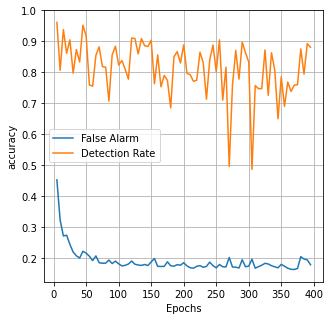

In [109]:
if if_fine_tuning == True:

    print_model_info(
        model_index,
        time_steps,
        eta,
        input_train_data,
        output_train_data,
        input_validation_data,
        output_validation_data,
        set_overlapping,
        overlapping,
        batch_size,
        set_batch_size,
    )
    print()

    epochs = 400
    epochs_step = 5
    plot_range = 1000
    threshold = 0.0032
    feature_list = [0, 43]
    epoch_start = 0

    samplesize_folder = "/samplesize=20000"

    model_folder = "/model" + str(model_index)
    model_fit_verbose = 0

    if os_windows:
        model_pathAndname = "C:/Users/liang/Masterarbeit_Jupyter_Lab/modelAndweights" + samplesize_folder + model_folder
    else:
        model_pathAndname = "modelAndweights" + samplesize_folder + model_folder

    # build a new model
    model = build_model(model_index, time_steps, set_batch_size, batch_size, sparsity_penalty, sparsity_para, hiding_dim)

    false_alarm, detection_rate = fit_epochs_3D(
        model_pathAndname,
        model,
        epochs,
        epochs_step,
        plot_range,
        input_train_data,
        fault_free_test1_normalized_3D,
        fault_free_test2_normalized_3D,
        faultytrain_faultfree0_20_normalized_3D,
        faultytest_faultfree0_160_normalized_3D,
        faulty_train_normalized_3D,
        faulty_test_normalized_3D,
        model_fit_verbose,
        threshold,
        feature_list,
        epoch_start,
    )

### 6 - test loaded model

In [110]:
# if_test_loaded_model = True
# if_test_loaded_model = False

if if_test_loaded_model:
    model_pathAndname = "C:/Users/liang/Masterarbeit_Jupyter_Lab/modelAndweights/good_result/model_index=0.0,samplesize=20000,No.=001/model0.0_epoch=80.json"
    weight_pathAndname = "C:/Users/liang/Masterarbeit_Jupyter_Lab/modelAndweights/good_result/model_index=0.0,samplesize=20000,No.=001/model0.0_weights_epoch=80.h5"

    model = load_model_weights(model_pathAndname, weight_pathAndname)

    fault_free_train_normalized_pred_3D = model.predict(fault_free_train_samplesize250000_normalized_3D)

#     fault_free_test_samplesize480000_normalized_pred_3D = model.predict(fault_free_test_samplesize480000_normalized_3D)

    fault_free_test1_normalized_pred_3D = model.predict(fault_free_test1_normalized_3D)
    fault_free_test2_normalized_pred_3D = model.predict(fault_free_test2_normalized_3D)
    faulty_train_normalized_pred_3D = model.predict(faulty_train_normalized_3D)
    faulty_test_normalized_pred_3D = model.predict(faulty_test_normalized_3D)

    # detect test----------------------------------------
    threshold = 0.0032
    plot_range = 2000
    feature_list = [0, 43]
    # feature_list=[0,18,20,43,45]
    pred_error_3D(
        threshold,
        feature_list,
        plot_range,
        fault_free_train_samplesize250000_normalized_3D,
        fault_free_train_normalized_pred_3D,
        "fault_free_train",
        overlapping,
        set_overlapping,
    )

#     if os_windows:
#         pred_error_3D(
#             threshold,
#             feature_list,
#             plot_range,
#             fault_free_test_samplesize480000_normalized_3D,
#             fault_free_test_samplesize480000_normalized_pred_3D,
#             "fault_free_test_samplesize480000",
#             overlapping,
#             set_overlapping,
#         )

    pred_error_3D(
        threshold,
        feature_list,
        plot_range,
        fault_free_test1_normalized_3D,
        fault_free_test1_normalized_pred_3D,
        "fault_free_test1",
        overlapping,
        set_overlapping,
    )
    pred_error_3D(
        threshold,
        feature_list,
        plot_range,
        fault_free_test2_normalized_3D,
        fault_free_test2_normalized_pred_3D,
        "fault_free_test2",
        overlapping,
        set_overlapping,
    )
    pred_error_3D(
        threshold,
        feature_list,
        plot_range,
        faulty_train_normalized_3D,
        faulty_train_normalized_pred_3D,
        "faulty_train",
        overlapping,
        set_overlapping,
    )
    pred_error_3D(
        threshold, feature_list, plot_range, faulty_test_normalized_3D, faulty_test_normalized_pred_3D, "faulty_test", overlapping, set_overlapping,
    )

NameError: name 'if_test_loaded_model' is not defined

### 7 - temporally test

In [ ]:
# model_pathAndname = "C:/Users/liang/Masterarbeit_Jupyter_Lab/modelAndweights/good_result/model_index=0.0,samplesize=20000,No.=001/model0.0_epoch=80.json"
# weight_pathAndname = "C:/Users/liang/Masterarbeit_Jupyter_Lab/modelAndweights/good_result/model_index=0.0,samplesize=20000,No.=001/model0.0_weights_epoch=80.h5"
# model_001 = load_model_weights(model_pathAndname, weight_pathAndname)

In [ ]:
def add_layer_to_autoencoder(model, encoding_dim, activation="relu", kernel_initializer="he_uniform"):
    # remember the current output layer
    output_layer = model.layers[-1]
    # remove the output layer
    model.pop()
    # mark all remaining layers as non-trainable
    for layer in model.layers:
        layer.trainable = False
    # add a new hidden layer
    model.add(layers.Dense(encoding_dim, activation=activation, kernel_initializer=kernel_initializer))
    model.add(layers.RepeatVector(1))
    # re-add the output layer
    model.add(output_layer)
    
    #     # fit model
    #     model.fit(trainX, trainX, epochs=100, verbose=0)
    #     # evaluate reconstruction loss
    #     train_mse = model.evaluate(trainX, trainX, verbose=0)
    #     test_mse = model.evaluate(testX, testX, verbose=0)
    #     print("> reconstruction error train=%.3f, test=%.3f" % (train_mse, test_mse))
    
    keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
    return model

### 8 - layer-wise training

In [ ]:
# sparsity_penalty = 0.1
# sparsity_para = 0
# hiding_dim = 48

# input_layer = keras.Input(shape=(1, 52))
# dense_layer_1 = layers.Dense(hiding_dim, activation="sigmoid")(input_layer)
# output_layer = layers.Dense(52, activation="tanh")(dense_layer_1)
# output_layer = layers.concatenate([dense_layer_1, output_layer])
# model_001 = keras.Model(inputs=input_layer, outputs=output_layer)
# model_001.compile(loss=custom_loss_001(sparsity_penalty, sparsity_para, hiding_dim), optimizer="adam", metrics=[custom_accuracy_001(hiding_dim)])
# # model_001.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
# keras.utils.plot_model(model_001, show_shapes=True, show_layer_names=True)

In [ ]:
# fault_free_train_normalized_3D = fault_free_train_samplesize20000_normalized_3D
# model_001.fit(
#     fault_free_train_normalized_3D, fault_free_train_normalized_3D, epochs=50, verbose=2,
# )

In [ ]:
# if_fine_tuning = True
# # if_fine_tuning = False

# if if_fine_tuning == True:
#     epochs = 200
#     epochs_step = 5
#     plot_range = 1000
#     threshold = 0.0032
#     feature_list = [0, 43]
#     epoch_start = 5

#     input_train_data = fault_free_train_normalized_3D

#     samplesize_folder = "/samplesize=20000"

#     model_folder = "/model" + "0.3_sparse"
#     model_fit_verbose = 0

#     if os_windows:
#         model_pathAndname = "C:/Users/liang/Masterarbeit_Jupyter_Lab/modelAndweights" + samplesize_folder + model_folder
#     else:
#         model_pathAndname = "modelAndweights" + samplesize_folder + model_folder

#     # build a new model
#     #     model = build_model(model_index, time_steps, set_batch_size, batch_size)
#     model = model_001

#     false_alarm, detection_rate = fit_epochs_3D(
#         model_pathAndname,
#         model,
#         epochs,
#         epochs_step,
#         plot_range,
#         input_train_data,
#         input_train_data,
#         fault_free_test2_normalized_3D,
#         faulty_train_normalized_3D,
#         faulty_test_normalized_3D,
#         model_fit_verbose,
#         threshold,
#         feature_list,
#         epoch_start,
#         set_half_output=True,
#         hiding_dim=hiding_dim,
#     )